In [1]:
import os
from fs_solver import *
#from FsSolver import *

Libraries fetched!...



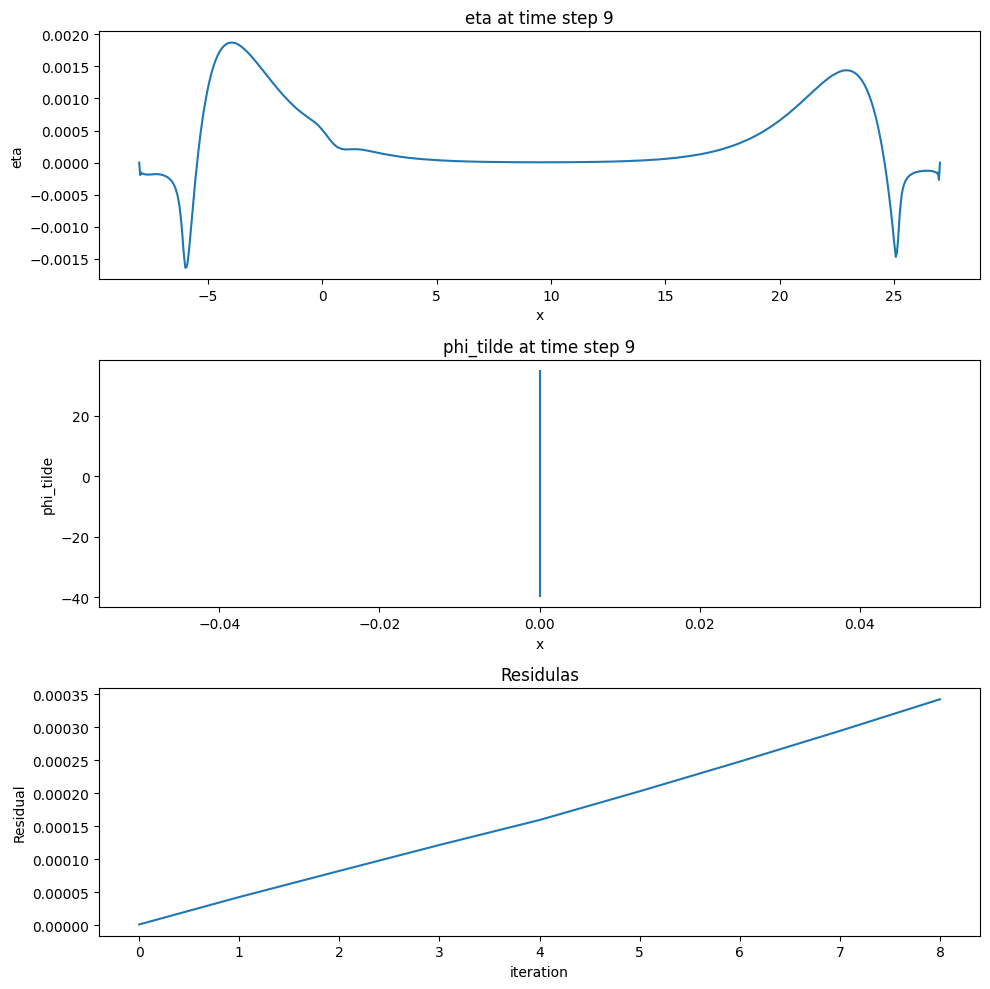

In [2]:
from fs_solver import *
eta = np.load("./results/eta.npy")
phi = np.load("./results/phiTilde.npy")
fs_xs = np.load("./results/fs_xs.npy")
residuals = np.load("./results/residuals.npy")
residuals, time_step = residuals[:,0], residuals[:,1]

fig, ax = plt.subplots(3, 1, figsize = (10,10))

time = np.where(time_step == 0)[0][0] - 1
ax[0].plot(fs_xs[time], eta[time] - 1)
ax[0].set_title(f"eta at time step {time}" )
ax[0].set_xlabel("x")
ax[0].set_ylabel("eta")

ax[1].plot(fs_xs[10], phi[time])
ax[1].set_title(f"phi_tilde at time step {time}" )
ax[1].set_xlabel("x")
ax[1].set_ylabel("phi_tilde")

ax[2].plot(residuals[:time])
ax[2].set_title("Residulas")
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("Residual")

plt.tight_layout()
plt.show()

In [3]:
time_step

array([0.005, 0.01 , 0.015, ..., 0.   , 0.   , 0.   ], shape=(5000,))